In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay,precision_score,recall_score,f1_score,roc_curve,log_loss,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('HeartDiesease.csv')
data.head(5)

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [2]:
Y=data["target"]
X=data.drop("target",axis=1)

In [3]:
sc = StandardScaler()
X=sc.fit_transform(X)

In [4]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.25,random_state=42)

In [5]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((892, 11), (298, 11), (892,), (298,))

### KNeighborsClassifier

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
errors = []
k=list(np.arange(2,15,2))
for i in k:
    knn = KNeighborsClassifier(n_neighbors=i,n_jobs=-1)
    knn.fit(x_train,y_train)
    sig_clf = CalibratedClassifierCV(estimator=knn,method='sigmoid')
    sig_clf.fit(x_train,y_train)
    y_pred = sig_clf.predict_proba(x_test)
    loss = log_loss(y_test,y_pred)
    print("knn k :{} log_loss :{}".format(i,loss))
    errors.append(loss)

knn k :2 log_loss :0.3330012093107427
knn k :4 log_loss :0.3258449121518305
knn k :6 log_loss :0.32557692120668635
knn k :8 log_loss :0.3328125654133603
knn k :10 log_loss :0.3420921827250613
knn k :12 log_loss :0.3465809588456776
knn k :14 log_loss :0.3514073134473192


In [45]:
print("best k :{}".format(k[np.argmin(errors)]))
print("min log_loss :{}".format(errors[np.argmin(errors)]))

best k :6
min log_loss :0.32557692120668635


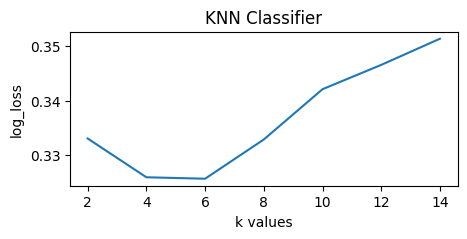

In [46]:
plt.figure(figsize=(5,2))
plt.title("KNN Classifier")
plt.xlabel("k values")
plt.ylabel("log_loss")
plt.plot(k,errors)
plt.show()

In [47]:
knn = KNeighborsClassifier(n_neighbors=6,n_jobs=-1)
knn.fit(x_train,y_train)
sig_clf = CalibratedClassifierCV(estimator=knn,method='sigmoid')
sig_clf.fit(x_train,y_train)
cvalidate = cross_validate(sig_clf,X,Y,cv=5,scoring="accuracy",return_train_score=True)
y_pred = sig_clf.predict_proba(x_test)[:,1]
print("train_score",cvalidate["train_score"].mean())
print("test_score",cvalidate["test_score"].mean())

train_score 0.8842436974789916
test_score 0.838655462184874


<Figure size 600x200 with 0 Axes>

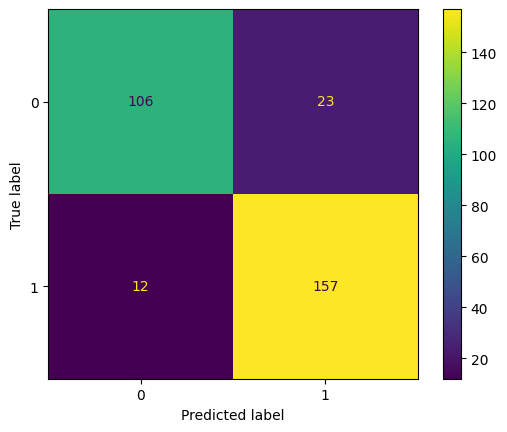

In [48]:
cnfmx = confusion_matrix(y_test,sig_clf.predict(x_test))
plt.figure(figsize=(6,2))
cnfmxDisplay = ConfusionMatrixDisplay(cnfmx)
cnfmxDisplay.plot()
plt.show()

In [59]:
y_predicted=[]
for i in y_pred:
    if i>0.5:
       y_predicted.append(1)
    else:
       y_predicted.append(0) 

print("precision score :{}".format(round(precision_score(y_test, y_predicted),3)))
print("recall score :{}".format(round(recall_score(y_test, y_predicted),3)))
print("f1 score :{}".format(round(f1_score(y_test, y_predicted),3)))

precision score :0.872
recall score :0.929
f1 score :0.9


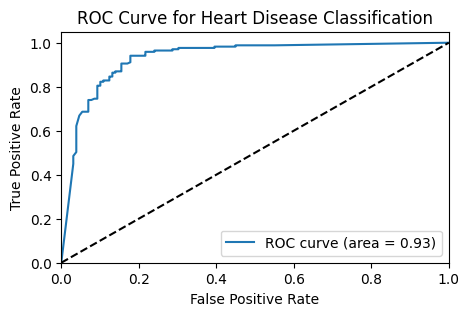

In [60]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred) 
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,3))  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Heart Disease Classification')
plt.legend()
plt.show()

## Logistic Regression

In [61]:
alpha = [10**i for i in range(-5,2)]
alpha

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]

In [62]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

errors = []
for i in alpha:
    clf = SGDClassifier(loss="log_loss",penalty='l2',alpha=i,n_jobs=-1,random_state=42)
    clf.fit(x_train,y_train)
    sig_clf = CalibratedClassifierCV(estimator=clf,method='sigmoid')
    sig_clf.fit(x_train,y_train)
    y_pred = sig_clf.predict_proba(x_test)[:,1]
    loss = log_loss(y_test,y_pred)
    print("alpha :{} log_loss :{}".format(i,loss))
    errors.append(loss)

alpha :1e-05 log_loss :0.4404433984681766
alpha :0.0001 log_loss :0.40210448491467526
alpha :0.001 log_loss :0.37891189977110407
alpha :0.01 log_loss :0.3790346122422069
alpha :0.1 log_loss :0.38059753514502176
alpha :1 log_loss :0.38537525087987234
alpha :10 log_loss :0.38752495087842564


best k :0.001
min log_loss :0.37891189977110407


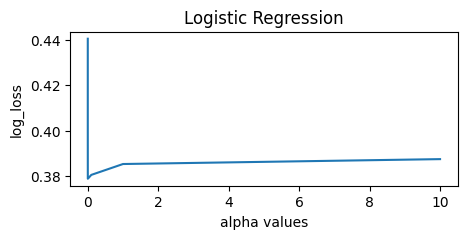

In [63]:
print("best k :{}".format(alpha[np.argmin(errors)]))
print("min log_loss :{}".format(errors[np.argmin(errors)]))

plt.figure(figsize=(5,2))
plt.title("Logistic Regression")
plt.xlabel("alpha values")
plt.ylabel("log_loss")
plt.plot(alpha,errors)
plt.show()

In [64]:
clf = SGDClassifier(loss="log_loss",penalty='l2',alpha=0.001,n_jobs=-1,random_state=42)
knn.fit(x_train,y_train)
sig_clf = CalibratedClassifierCV(estimator=clf,method='sigmoid')
sig_clf.fit(x_train,y_train)
cvalidate = cross_validate(sig_clf,X,Y,cv=5,scoring="accuracy",return_train_score=True)
y_pred = sig_clf.predict_proba(x_test)[:,1]
print("train_score",cvalidate["train_score"].mean())
print("test_score",cvalidate["test_score"].mean())

train_score 0.8376050420168066
test_score 0.8142857142857143


<Figure size 600x200 with 0 Axes>

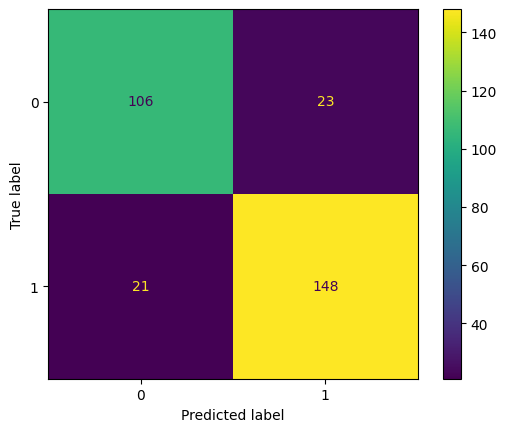

In [65]:
cnfmx = confusion_matrix(y_test,sig_clf.predict(x_test))
plt.figure(figsize=(6,2))
cnfmxDisplay = ConfusionMatrixDisplay(cnfmx)
cnfmxDisplay.plot()
plt.show()

In [66]:
y_predicted=[]
for i in y_pred:
    if i>0.5:
       y_predicted.append(1)
    else:
       y_predicted.append(0) 

print("precision score :{}".format(round(precision_score(y_test, y_predicted),3)))
print("recall score :{}".format(round(recall_score(y_test, y_predicted),3)))
print("f1 score :{}".format(round(f1_score(y_test, y_predicted),3)))

precision score :0.865
recall score :0.876
f1 score :0.871


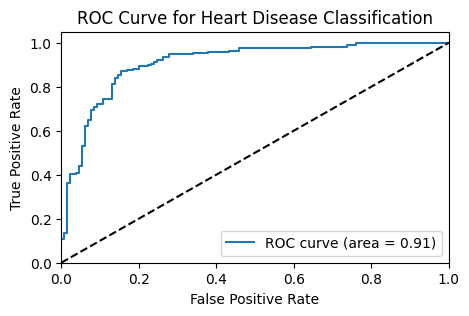

In [67]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred) 
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,3))  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Heart Disease Classification')
plt.legend()
plt.show()

## SVM

In [68]:
alpha = [10**i for i in range(-5,2)]

alpha :1e-05 log_loss :0.45499227858573915
alpha :0.0001 log_loss :0.3875340079402868
alpha :0.001 log_loss :0.3917516785285038
alpha :0.01 log_loss :0.38998855388028514
alpha :0.1 log_loss :0.387812611422051
alpha :1 log_loss :0.38579838668607863
alpha :10 log_loss :0.38777436347657424
best alpha :1
min log_loss :0.38579838668607863


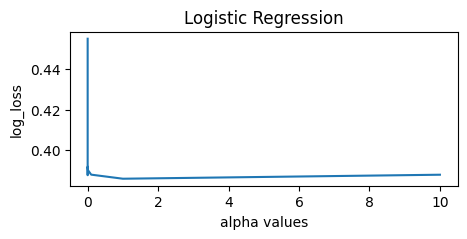

In [69]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

errors = []
for i in alpha:
    clf = SGDClassifier(loss="hinge",penalty='l2',alpha=i,n_jobs=-1,random_state=42)
    clf.fit(x_train,y_train)
    sig_clf = CalibratedClassifierCV(estimator=clf,method='sigmoid')
    sig_clf.fit(x_train,y_train)
    y_pred = sig_clf.predict_proba(x_test)[:,1]
    loss = log_loss(y_test,y_pred)
    print("alpha :{} log_loss :{}".format(i,loss))
    errors.append(loss)

print("best alpha :{}".format(alpha[np.argmin(errors)]))
print("min log_loss :{}".format(errors[np.argmin(errors)]))

plt.figure(figsize=(5,2))
plt.title("Logistic Regression")
plt.xlabel("alpha values")
plt.ylabel("log_loss")
plt.plot(alpha,errors)
plt.show()

In [70]:
clf = SGDClassifier(loss="hinge",penalty='l2',alpha=1,n_jobs=-1,random_state=42)
knn.fit(x_train,y_train)
sig_clf = CalibratedClassifierCV(estimator=clf,method='sigmoid')
sig_clf.fit(x_train,y_train)
cvalidate = cross_validate(sig_clf,X,Y,cv=5,scoring="accuracy",return_train_score=True)
y_pred = sig_clf.predict_proba(x_test)[:,1]
print("train_score",cvalidate["train_score"].mean())
print("test_score",cvalidate["test_score"].mean())

train_score 0.8243697478991596
test_score 0.8184873949579832


<Figure size 600x200 with 0 Axes>

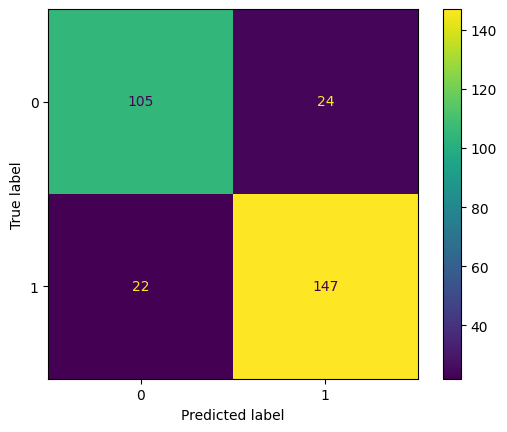

In [71]:
cnfmx = confusion_matrix(y_test,sig_clf.predict(x_test))
plt.figure(figsize=(6,2))
cnfmxDisplay = ConfusionMatrixDisplay(cnfmx)
cnfmxDisplay.plot()
plt.show()

In [72]:
y_predicted=[]
for i in y_pred:
    if i>0.5:
       y_predicted.append(1)
    else:
       y_predicted.append(0) 

print("precision score :{}".format(round(precision_score(y_test, y_predicted),3)))
print("recall score :{}".format(round(recall_score(y_test, y_predicted),3)))
print("f1 score :{}".format(round(f1_score(y_test, y_predicted),3)))

precision score :0.86
recall score :0.87
f1 score :0.865


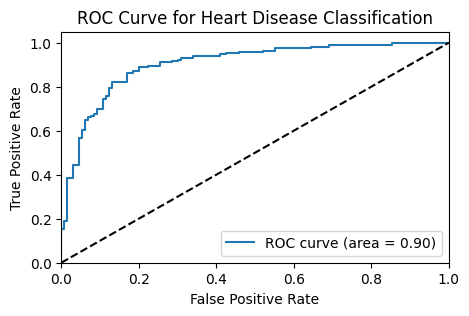

In [73]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred) 
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,3))  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Heart Disease Classification')
plt.legend()
plt.show()

## RandomForest Classifier

n_estimators :5 log_loss :0.2994279202121158
n_estimators :10 log_loss :0.2682040477449635
n_estimators :15 log_loss :0.25901245953953467
n_estimators :20 log_loss :0.26003532059716034
n_estimators :25 log_loss :0.25416871032741317
n_estimators :30 log_loss :0.2524245364192671
n_estimators :35 log_loss :0.2521561277993668
n_estimators :40 log_loss :0.25048073362273293
n_estimators :45 log_loss :0.24813237178555297
n_estimators :50 log_loss :0.24996945878233295
n_estimators :55 log_loss :0.24900983342311708
n_estimators :60 log_loss :0.2495814819327543
n_estimators :65 log_loss :0.2504228267919301
n_estimators :70 log_loss :0.24860818836208862
n_estimators :75 log_loss :0.248042497240112
n_estimators :80 log_loss :0.24866805942778655
n_estimators :85 log_loss :0.24861289824858662
n_estimators :90 log_loss :0.2481227262928998
n_estimators :95 log_loss :0.2476408436973987


best alpha :95
min log_loss :0.2476408436973987


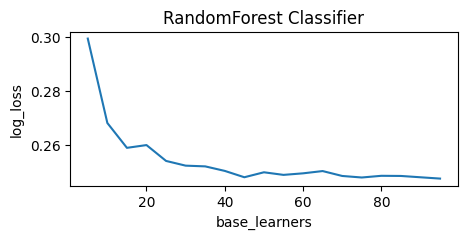

In [74]:
errors = []
base_learners = [i for i in np.arange(5,100,5)]
for i in base_learners:
    clf = RandomForestClassifier(n_estimators=i,criterion="gini",random_state=42)
    clf.fit(x_train,y_train)
    sig_clf = CalibratedClassifierCV(estimator=clf,method='sigmoid',cv=5,n_jobs=-1)
    sig_clf.fit(x_train,y_train)
    y_pred = sig_clf.predict_proba(x_test)[:,1]
    loss = log_loss(y_test,y_pred)
    print("n_estimators :{} log_loss :{}".format(i,loss))
    errors.append(loss)

print("\n")
print("best alpha :{}".format(base_learners[np.argmin(errors)]))
print("min log_loss :{}".format(errors[np.argmin(errors)]))

plt.figure(figsize=(5,2))
plt.title("RandomForest Classifier")
plt.xlabel("base_learners")
plt.ylabel("log_loss")
plt.plot(base_learners,errors)
plt.show()    
    

In [75]:
clf = RandomForestClassifier(n_estimators=95,criterion="gini",random_state=42)
clf.fit(x_train,y_train)
sig_clf = CalibratedClassifierCV(estimator=clf,method='sigmoid')
sig_clf.fit(x_train,y_train)
cvalidate = cross_validate(sig_clf,X,Y,cv=5,scoring="accuracy",return_train_score=True)
y_pred = sig_clf.predict_proba(x_test)[:,1]
print("train_score",cvalidate["train_score"].mean())
print("test_score",cvalidate["test_score"].mean())

train_score 0.9974789915966387
test_score 0.9319327731092437


<Figure size 600x200 with 0 Axes>

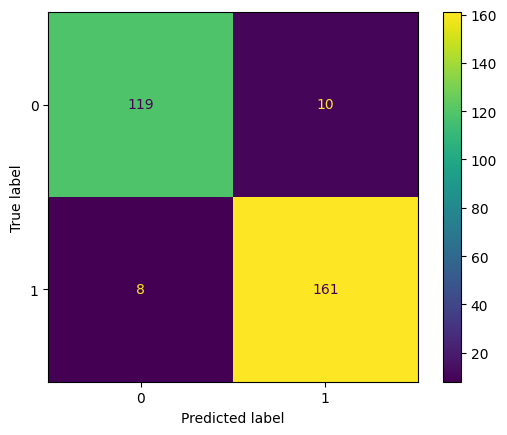

In [76]:
cnfmx = confusion_matrix(y_test,sig_clf.predict(x_test))
plt.figure(figsize=(6,2))
cnfmxDisplay = ConfusionMatrixDisplay(cnfmx)
cnfmxDisplay.plot()
plt.show()

In [78]:
y_predicted=[]
for i in y_pred:
    if i>0.5:
       y_predicted.append(1)
    else:
       y_predicted.append(0) 

print("precision score :{}".format(round(precision_score(y_test, y_predicted),3)))
print("recall score :{}".format(round(recall_score(y_test, y_predicted),3)))
print("f1 score :{}".format(round(f1_score(y_test, y_predicted),3)))

precision score :0.942
recall score :0.953
f1 score :0.947


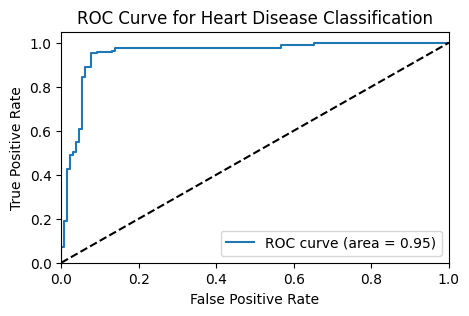

In [77]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred) 
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,3))  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Heart Disease Classification')
plt.legend()
plt.show()

## XGBoost Classifier

In [37]:
import xgboost as xgb
params = {}
params["booster"]="gbtree"
params["device"]="cuda"
params["eta"]=0.3
params["max_depth"]=6
params["objective"]="reg:logistic"

d_train = xgb.DMatrix(x_train,label=y_train)
d_test = xgb.DMatrix(x_test,label=y_test)
watchlist = [(d_train,"d_train"),(d_test,"d_test")]
bst = xgb.train(params=params,dtrain=d_train,num_boost_round=2000,verbose_eval=10)
xgb.DMatrix(x_train,y_train)
y_pred = bst.predict(d_test)
print("loss :",log_loss(y_test,y_pred))

loss : 0.31618141675758576


## Compare Results 

In [38]:
import pandas as pd
data = [["KNeighborsClassifier", 0.88,0.83,0.32,0.93,"K=6"],
       ["LogisticRegression", 0.83,0.81,0.37,0.91,"alpha : 0.001"],
       ["Support Vector Machine (SVM)", 0.82,0.81,0.38,0.90,"alpha=1"],
       ["Random Forest", 0.99,0.93,0.24,0.95,"n_estimators=95"],
       ["XGBoost", "--","--",0.31,"--","--"]]
pd.DataFrame(data, columns=["model","train score","test score","log_loss","auc","hyper parameters"])

,model,train score,test score,log_loss,auc,hyper parameters
0,KNeighborsClassifier,0.88,0.83,0.32,0.93,K=6
1,LogisticRegression,0.83,0.81,0.37,0.91,alpha : 0.001
2,Support Vector Machine (SVM),0.82,0.81,0.38,0.9,alpha=1
3,Random Forest,0.99,0.93,0.24,0.95,n_estimators=95
4,XGBoost,--,--,0.31,--,--


### Deploye and Validate Model

In [39]:
import pickle
pickle.dump(clf,open("hdmodel.pkl","wb"))

In [40]:
def predict(input1):
    loaded_model = pickle.load(open("hdmodel.pkl","rb"))
    res=loaded_model.predict(input1)[0]
    if res == 0:
      print("no heart disease")
    else:
      print("heart disease")

In [43]:
input_data = [40,1,2,140,289,0,0,172,0,0.0,1]
predict([input_data])

no heart disease
